Eğitim seti: 162770 örnek, Doğrulama seti: 19867 örnek
Found 162770 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5087/5087 ━━━━━━━━━━━━━━━━━━━━ 1564s 305ms/step - accuracy: 0.6889 - loss: 0.5914 - val_accuracy: 0.7490 - val_loss: 0.5058
Epoch 2/10
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 895s 176ms/step - accuracy: 0.7362 - loss: 0.5309 - val_accuracy: 0.7501 - val_loss: 0.5054
Epoch 3/10
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 877s 172ms/step - accuracy: 0.7424 - loss: 0.5208 - val_accuracy: 0.7563 - val_loss: 0.4973
Epoch 4/10
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 877s 172ms/step - accuracy: 0.7459 - loss: 0.5177 - val_accuracy: 0.7604 - val_loss: 0.4917
Epoch 5/10
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 886s 174ms/step - accuracy: 0.7494 - loss: 0.5117 - val_accuracy: 0.7689 - val_loss: 0.4805
Epoch 6/10
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 882s 173ms/step - accuracy: 0.7506 - loss: 0.5107 - val_accuracy: 0.7575 - val_loss: 0.4930
Epoch 7/10
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 875s 172ms/step - accuracy: 0.7526 - loss: 0.5062 - val_accuracy: 0.7652 - val_loss: 0.4822
Epoch 8/10
5087/5087 ━━━━━━━━━━━━━━━━━━━━ 893s 175ms/step - accuracy: 0.

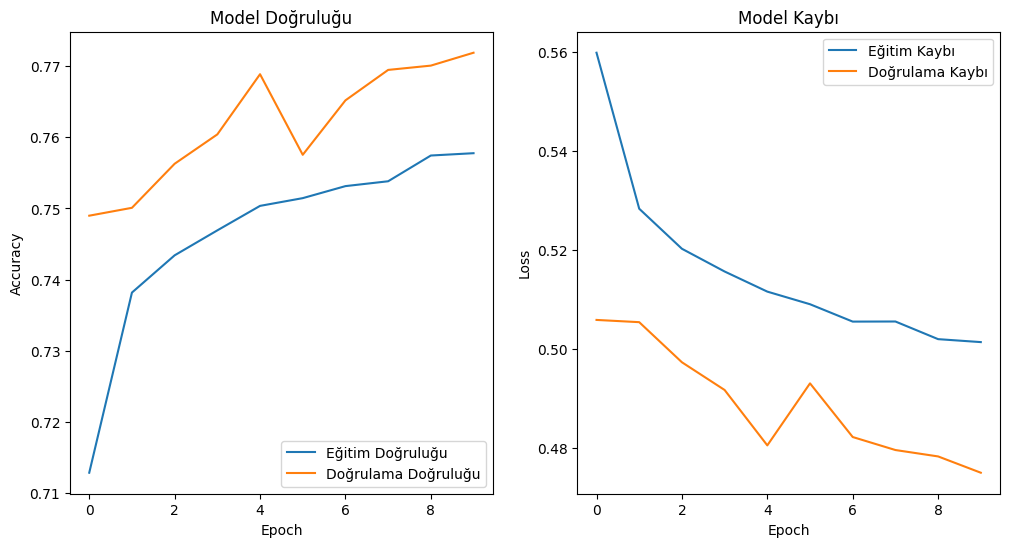

In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Hiperparametreler
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001
IMAGE_DIR = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
ATTR_PATH = "/kaggle/input/celeba-dataset/list_attr_celeba.csv"
PARTITION_PATH = "/kaggle/input/celeba-dataset/list_eval_partition.csv"

# Veri setini yükleme ve işleme
attr_df = pd.read_csv(ATTR_PATH)
partition_df = pd.read_csv(PARTITION_PATH)

# Smiling etiketini işaretleme
attr_df["smiling"] = attr_df["Smiling"].apply(lambda x: "smiling" if x == 1 else "not_smiling")

# Eğitim ve doğrulama veri çerçevelerini oluşturma
partition_df = partition_df.rename(columns={"image_id": "image_id", "partition": "partition"})
train_df = partition_df[partition_df["partition"] == 0]
val_df = partition_df[partition_df["partition"] == 1]

train_df = train_df.merge(attr_df[["image_id", "smiling"]], on="image_id")
val_df = val_df.merge(attr_df[["image_id", "smiling"]], on="image_id")

# Veri çerçevelerinin boş olmadığını kontrol et
if train_df.empty:
    raise ValueError("Eğitim veri çerçevesi boş!")
if val_df.empty:
    raise ValueError("Doğrulama veri çerçevesi boş!")

print(f"Eğitim seti: {len(train_df)} örnek, Doğrulama seti: {len(val_df)} örnek")

# Veri artırma
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Veri jeneratörleri
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=IMAGE_DIR,
    x_col="image_id",
    y_col="smiling",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=IMAGE_DIR,
    x_col="image_id",
    y_col="smiling",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Modeli oluştur
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False  # Önceden eğitilmiş ağı dondur

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # İkili sınıflandırma için sigmoid
])

# Modeli derle
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",  # Yeni format
        save_best_only=True,
        monitor="val_accuracy",
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True
    )
]

# Modeli eğit
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Modeli değerlendirme
loss, accuracy = model.evaluate(val_generator)
print(f"Doğrulama Kaybı: {loss}")
print(f"Doğrulama Doğruluğu: {accuracy}")

# Eğitim geçmişini görselleştirme
plt.figure(figsize=(12, 6))

# Doğruluk
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Eğitim Doğruluğu")
plt.plot(history.history["val_accuracy"], label="Doğrulama Doğruluğu")
plt.title("Model Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Kayıp
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Eğitim Kaybı")
plt.plot(history.history["val_loss"], label="Doğrulama Kaybı")
plt.title("Model Kaybı")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()